Since we are planning on working with spiking neural networks in our project, we will need to install the **"snntorch"** PyTorch-based library.

In [1]:
!pip install snntorch

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense

from datetime import datetime

import snntorch as snn
from snntorch import spikegen
from snntorch import surrogate
from snntorch import utils

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

The rise of renewable energy sources has introduced new paradigms in energy production and consumption, leading to the emergence of 'prosumers' who both consume and produce energy in bidirectional smart grids. However, managing supply and demand in this complex environment presents challenges, particularly in dynamically estimating grid stability considering technical and economic factors. Decentral Smart Grid Control (DSGC) systems, focusing on monitoring grid frequency, offer a solution. These systems utilize a mathematical model to predict grid instability based on power balance, participant response time, and energy price elasticity. However, executing this model involves simplifications, leading to issues like the "fixed inputs issue" and the "equality issue". To address these challenges, alternative approaches have been proposed. We will work with one today.

# Data loading and Preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The next step is to load our dataset from a CSV file into a pandas DataFrame. We then map categorical target labels, 'unstable' and 'stable', to numeric values 0 and 1.

In [4]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/BINL_Project/smart_grid_stability_augmented.csv')

# Map the target labels to numeric values
map1 = {'unstable': 0, 'stable': 1}
data['stabf'] = data['stabf'].replace(map1)

The dataset used in this exercise originates from simulations of grid stability within a reference 4-node star network, a configuration resembling a typical smart grid architecture.



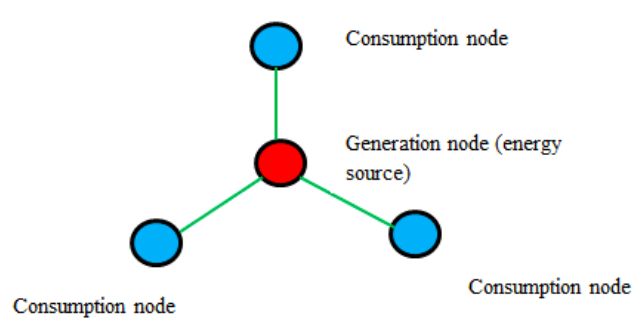

The original dataset contains 10,000 observations. As the reference grid is symetric, the dataset can be augmented in 3! (3 factorial) times, or 6 times, representing a permutation of the three consumers occupying three consumer nodes. The augmented version has then 60,000 observations. It also contains 12 primary predictive features and two dependent variables.

**Predictive features:**


1.   'tau1' to 'tau4': the reaction time of each network participant, a real value within the range 0.5 to 10 ('tau1' corresponds to the supplier node, 'tau2' to 'tau4' to the consumer nodes);
2.   'p1' to 'p4': nominal power produced (positive) or consumed (negative) by each network participant, a real value within the range -2.0 to -0.5 for consumers ('p2' to 'p4'). As the total power consumed equals the total power generated, p1 (supplier node) = - (p2 + p3 + p4);

3. 'g1' to 'g4': price elasticity coefficient for each network participant, a real value within the range 0.05 to 1.00 ('g1' corresponds to the supplier node, 'g2' to 'g4' to the consumer nodes; 'g' stands for 'gamma');

**Dependent variables:**

1. 'stab': the maximum real part of the characteristic differentia equation root (if positive, the system is linearly unstable; if negative, linearly stable);

2. 'stabf': a categorical (binary) label ('stable' or 'unstable').

As there is a direct relationship between 'stab' and 'stabf' ('stabf' = 'stable' if 'stab' <= 0, 'unstable' otherwise), 'stab' will be dropped and 'stabf' will remain as the sole dependent variable.

As the dataset content comes from simulation exercises, there are no missing values. Also, all features are originally numerical, no feature coding is required. Such dataset properties allow for a direct jump to machine modeling without the need of data preprocessing or feature engineering.

The first step is to shuffle the rows of the dataset to ensure that it is randomly distributed.

In [5]:
data = data.sample(frac=1)

We then separate the features from the target variable by dropping the 'stab' and 'stabf' columns and extracting the 'stabf' values into a separate array. Finally, we normalize the input features using the StandardScaler from scikit-learn, transforming the features to have a mean of 0 and a standard deviation of 1. This normalization step ensures that all features contribute equally to the model and facilitates faster convergence during training.

In [6]:
# Separate features and target variable
X = data.drop(columns=['stab', 'stabf']).values
y = data['stabf'].values

# Data preprocessing: Normalize input features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
33634,5.038954,2.854975,6.760404,2.351099,3.825648,-1.047535,-1.600412,-1.177701,0.511728,0.535568,0.496353,0.271664,0.005923,0
59581,6.684220,8.547920,0.928134,2.203119,2.474923,-0.941681,-0.997293,-0.535949,0.506745,0.104241,0.518145,0.819234,-0.021735,1
32196,7.385124,7.146861,4.124532,5.814556,2.959897,-0.857065,-0.792537,-1.310295,0.422468,0.903830,0.532740,0.944374,0.084947,0
58914,4.790756,5.983650,4.769794,3.852234,4.646755,-0.771887,-1.949291,-1.925577,0.845140,0.207974,0.950446,0.583267,0.076599,0
43370,4.184940,5.264113,1.808347,8.353830,3.252513,-0.655789,-1.666511,-0.930212,0.643027,0.831909,0.552895,0.284864,0.028744,0


# Defining Model Architecture

The model used in this case will incorporate two primary types of layers: fully connected layers and Leaky Integrate-and-Fire (LIF) spiking neuron layers.

**Fully Connected Layers:**
*  Standard layers used in neural networks.
*  Transform input data from one dimension to another (e.g., input size to hidden size).
*  Perform linear transformations, mapping inputs to outputs through weight matrices and biases.

**Leaky Integrate-and-Fire (LIF) Layers:**

This layer mimics the behavior of biological neurons by accumulating input signals over time and emitting spikes when the threshold is reached. It incorporates a decay factor (beta) to model the leakage of the neuron's membrane potential, ensuring that the potential diminishes gradually if no new input is received. The layer uses surrogate gradients to approximate the non-differentiable spike function, allowing for gradient-based training. Parameters such as the threshold for spike generation and reset_mechanism for post-spike potential reset are crucial for simulating the dynamic, time-dependent nature of neuronal activity.

In [8]:
import snntorch.spikegen as spikegen
from snntorch.functional import accuracy_rate
from tqdm import tqdm

In [9]:
class SpikingMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SpikingMLP, self).__init__()
        spike_grad = surrogate.fast_sigmoid(slope=25)  # Surrogate gradient
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = snn.Leaky(beta=0.99, threshold=1, learn_beta=False,
                              reset_mechanism='subtract', spike_grad=spike_grad)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.lif2 = snn.Leaky(beta=0.99, threshold=1, learn_beta=False,
                              reset_mechanism='subtract', spike_grad=spike_grad, output=True)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        x = self.fc1(x)
        x, mem1 = self.lif1(x, mem1)
        x = self.fc2(x)
        x, mem2 = self.lif2(x, mem2)

        return x, mem2

# Defining Training and Evaluation Functions

The purpose of the training function is to iteratively train the SpikingMLP model over a specified number of epochs, ensuring that the model learns to make accurate predictions by adjusting its parameters based on the training data. This is achieved through a process that includes setting the model to training mode, zeroing gradients, performing forward and backward passes to compute and propagate errors, updating model parameters using an optimizer, and calculating accuracy to track performance. By doing so, the function aims to minimize the loss and improve the model's predictive accuracy over time, providing metrics after each epoch to monitor progress.









In [10]:
def train(model, train_loader, optimizer, criterion, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for data, targets in train_loader:
            optimizer.zero_grad()
            outputs, _ = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total * 100  # Calculate accuracy in percentage
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.4f}, Training Accuracy: {accuracy:.2f}%")

# Cross-Validation

To evaluate the performance of our model, we will use a cross validation approach. It normally provides a more accurate estimate of the model performance by training and testing the model on multiple subsets of the data and helps avoid overfitting.

In [11]:
# Define cross-validation parameters
num_folds = 5
num_epochs = 5
batch_size = 32
learning_rate = 0.001

# Initialize the StratifiedKFold
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

We used *StratifiedKFold* to ensure that each fold has a balanced representation of each class, which is crucial for maintaining the integrity of the model evaluation, especially for imbalanced datasets.

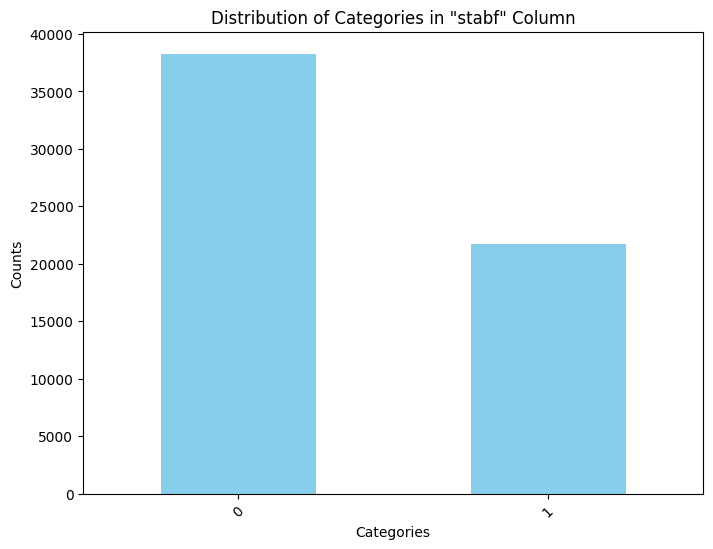

In [12]:
value_counts = data['stabf'].value_counts()

# Plot the value counts
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Categories in "stabf" Column')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()


In [13]:
# Initialize lists to store evaluation metrics for each fold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
conf_matrices = []
sns.set()
start_time = datetime.now()

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold+1}:")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Convert data into PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # Create PyTorch datasets and dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the SNN model, criterion, optimizer
    input_size = X_train.shape[1]
    hidden_size = 100
    output_size = 2

    model = SpikingMLP(input_size, hidden_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train(model, train_loader, optimizer, criterion, num_epochs)

    # Evaluate on validation set
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data, targets in val_loader:
            outputs, _ = model(data)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(targets.numpy())

    # Compute and store confusion matrix for the fold
    conf_matrix = confusion_matrix(true_labels, predictions)
    conf_matrices.append(conf_matrix)

    # Compute performance metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    print(f"Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
    print("--------------------------------------------------")

end_time = datetime.now()

print('\nStart time', start_time)
print('End time', end_time)
print('Time elapsed', end_time - start_time)

Fold 1:
Epoch 1/5, Training Loss: 0.4870, Training Accuracy: 81.44%
Epoch 2/5, Training Loss: 0.4093, Training Accuracy: 89.38%
Epoch 3/5, Training Loss: 0.3903, Training Accuracy: 91.41%
Epoch 4/5, Training Loss: 0.3819, Training Accuracy: 92.47%
Epoch 5/5, Training Loss: 0.3773, Training Accuracy: 93.03%
Accuracy: 0.930, Precision: 0.937, Recall: 0.864, F1: 0.899
--------------------------------------------------
Fold 2:
Epoch 1/5, Training Loss: 0.4879, Training Accuracy: 81.36%
Epoch 2/5, Training Loss: 0.4066, Training Accuracy: 89.62%
Epoch 3/5, Training Loss: 0.3892, Training Accuracy: 91.68%
Epoch 4/5, Training Loss: 0.3809, Training Accuracy: 92.62%
Epoch 5/5, Training Loss: 0.3762, Training Accuracy: 93.21%
Accuracy: 0.931, Precision: 0.939, Recall: 0.866, F1: 0.901
--------------------------------------------------
Fold 3:
Epoch 1/5, Training Loss: 0.4915, Training Accuracy: 80.41%
Epoch 2/5, Training Loss: 0.4186, Training Accuracy: 88.34%
Epoch 3/5, Training Loss: 0.4026, 

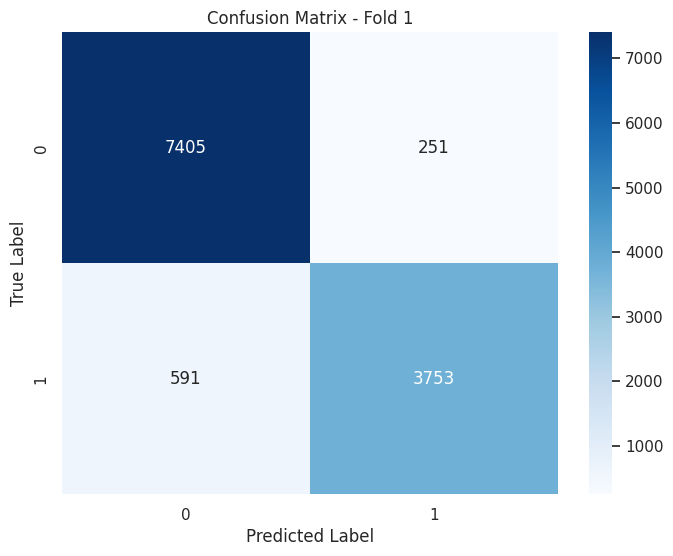

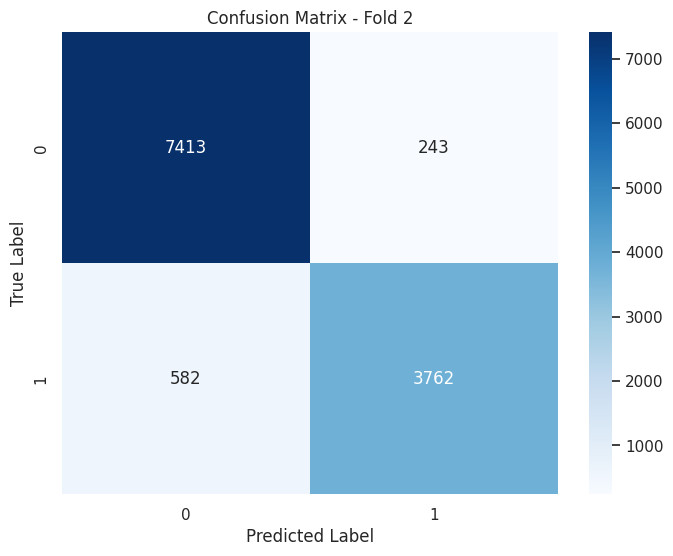

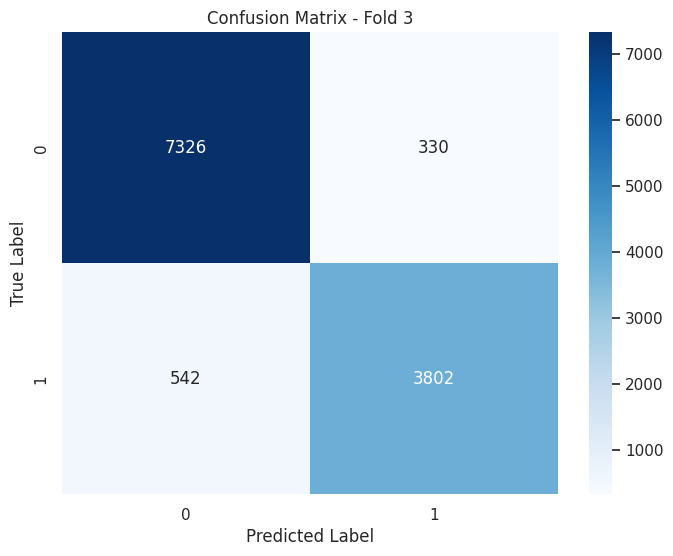

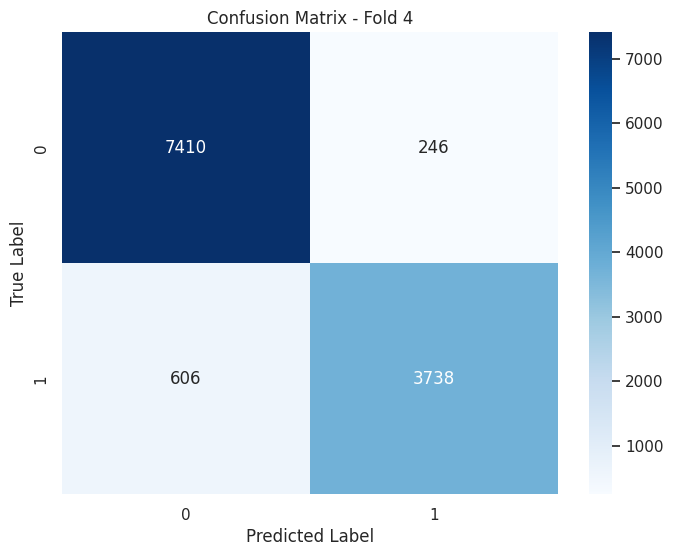

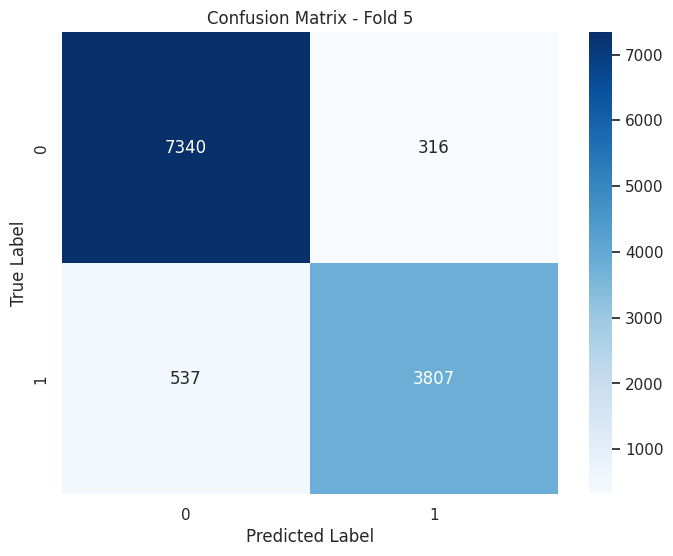

Performance in Accuracy: Mean = 0.929, Std = 0.001
Performance in Precision: Mean = 0.932, Std = 0.008
Performance in Recall: Mean = 0.868, Std = 0.006
Performance in F1-score: Mean = 0.899, Std = 0.001


In [14]:
# Plot confusion matrices
for fold, conf_matrix in enumerate(conf_matrices):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.title(f'Confusion Matrix - Fold {fold+1}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Compute mean and standard deviation across all folds
print("Performance in Accuracy: Mean = {:.3f}, Std = {:.3f}".format(np.mean(accuracy_list), np.std(accuracy_list)))
print("Performance in Precision: Mean = {:.3f}, Std = {:.3f}".format(np.mean(precision_list), np.std(precision_list)))
print("Performance in Recall: Mean = {:.3f}, Std = {:.3f}".format(np.mean(recall_list), np.std(recall_list)))
print("Performance in F1-score: Mean = {:.3f}, Std = {:.3f}".format(np.mean(f1_list), np.std(f1_list)))

Across all folds, the model's training accuracy and loss showed consistent improvement with each epoch, indicating effective learning. Upon completing the cross-validation, the mean accuracy on the validation dataset was calculated to be 92.9%, reflecting a strong performance. The entire process was completed in approximately 2 minutes and 19 seconds.


It's important to note that we didn't specify a seed, so each run produces slightly different results. However, we consistently obtain excellent results, indicating that the performance is not due to chance.